# Fitting models to data 

A common scientific task is to formulate a mathematical model and 'fit' that model to experimental data. One of the simplest and most used ways of doing this is called 'Linear least squares regression'. It is what is usually meant when terms like  "regression", "linear regression" or "least squares" are used.

In the least squares method, we have a mathematical model, defined with a number of parameters, and some data points. As an example, a simple model (straight line) would be "y=mx + c" which has 2 parameters 'm' (the slope or gradienat of the line) and 'c' (the intercept. 

The regression process is one of optmising the 'fit' of the line to the data by establishing the 'best' values for the parameters that minimises the sum of the squared distances, or deviations, between the data points and the model.

In this notebook, we'll explore how to do this using some of the fitting tools and functions available with Python.

We'll do all the imports and other housekeeping we need here before moving on. You'll note that we'll be using both Matplotlib and Bokeh as display packages - just for variety, you could use either.

We also need to import packages from sciPy. (**.stats.lingress()**, **.optimize.curve_fit()**, and **.odr()**) but, unusually, we'll import these as we need them to emphasise their usage.


In [2]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_notebook, show

# These 2 lines just allow 'pretty' printing of pandas stuff - non-essential
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Set the size of subsequent plots
plt.rcParams['figure.figsize']=[10,6]


## 1. The data

For the purposes of the next few sections of this notebook, a file with data is provided ("line_data.csv" - later on you'll also use "gaus_rand.csv"). 

This is designed to represent typical experimental data that might be modeled with a straight line. There are 4 columns - 'xdat' and 'ydat', which are the x and y values, and 'xerr' and 'yerr' which are the estimated uncertainties or errors on the x and y data points.

First, we'll read in the data and make a rough plot.


,xdat,ydat,xerr,yerr
0,3.10,8.10,0.20,1.4
1,3.45,8.35,0.10,0.4
2,3.75,9.85,0.50,0.3
3,4.65,10.75,0.85,0.2
4,5.00,12.55,0.70,1.1


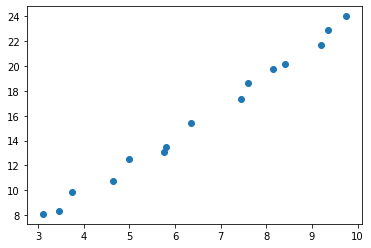

In [3]:
# Read in the data
df = pd.read_csv('line_data.csv')

# What does it look like? - just for info
df.head()

# Set up x and y - not strictly necessary, but convenient
x=df['xdat']
y=df['ydat']
y0=y

plt.scatter(x,y)

##  2. Simple regression - scipy linregress()

So, that looks like a straight line might fit - what's the bet fit we can obtain?

One of the simplest ways is to use a sciPy function: **scipy.stats.linregress()**, which is very easy to use.

This gives us a least squares fit, returning the slope, intercept, rvalue, pvalue and a standard error. The rvalue squared tells you something about the 'goodness' of the fit - the closer to 1 the better.


Gradient is 2.38, Intercept is 0.24 and standard error is 0.06


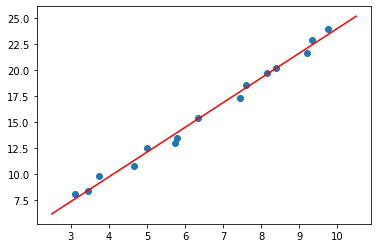

In [4]:
from scipy.stats import linregress

m,c,r_val,p_val,sterr = linregress(x,y)

print(f'Gradient is {m:.2f}, Intercept is {c:.2f} and standard error is {sterr:.2f}')

# Plot the line on to the data:
plt.scatter(x,y)
xlin = np.linspace(2.5,10.5,50)
plt.plot(xlin,(m*xlin+c), color='red')

## 3. Getting more statistical information

This is fine for many purposes and is pretty much what you get wen you fit a line to data in a speadsheet such as Microsoft Excel.

Often though, you need to know something more about how accurate the optimised parameters are. For this we need to use another sciPy function - scipy.optimize.curve_fit().

This is a much more general function that linregress() and allows you to define a model function that you want to fit - you are not constrained to a straight line. As it happens, in this case, we do actually want a straight line but we'll need to define it - in a specific manner using a function.

It returns 2 objects, one containing the optimised parameters to the model and a "covariance matrix" that contains quite a lot of statistical data. We can use this statistical data to get esimates of how accurate the returned optimised parameters are.

curve_fit() assumes that ydata = f(xdata, *params) + eps (where 'f' is your defined function)

The model function you define must  take the independent variable as the first argument and the parameters to fit as separate remaining arguments.

As usual it's probably easiest to present this as an example - using the data we've already got.

fit parameter 1-sigma error
***************************************************
m = 2.38 +- 0.06
c = 0.24 +- 0.42
***************************************************


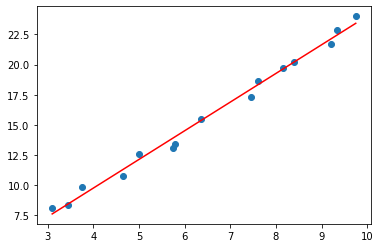

In [5]:
from scipy.optimize import curve_fit

# Define a simple, straight line model, accepting an x value or 1D array and using 
# gradient and intercept parameters. 
#
# As you can see if you passed this an x value it would calculate the corresponding y.
# If you pass it an numpy array or pandas series it will return a corresponding array
# of y values.
def stLineFit(x, m, c):
    return (m*x + c)

# Call the fitting function - which gives 2 retun values. The variables 'popt' and 'pcov' 
# are called this by convention but any 2 names would do.
popt, pcov = curve_fit(stLineFit, x, y)
# Calculate the 'accuracy' of the returned parameters
perr = np.sqrt(np.diag(pcov)) # error values are on the covariance matrix diagonal

# Now we can print out the optimised fit parameters and 1-sigma estimates
print('fit parameter 1-sigma error')
print('***************************************************')
print (f'm = {popt[0]:.2f} +- {perr[0]:.2f}')
print (f'c = {popt[1]:.2f} +- {perr[1]:.2f}')
print('***************************************************')

# Now plot the data and add the optimised line. WE could do this in exactly the same way as we
# did for the lingress() example, or, use our stLineFit() function:

plt.scatter(x,y)
plt.plot(x,stLineFit(x,m,c), color='red')


## 4. What if we have estimated uncertainties on the y axis?

Experimantal data often has (in fact, ought to have) estimates of how uncertain the measurement is - it has associated errors. 

Simple functions like linregress() treat all data points as equal. However, it's reasonable to suppose that data points with small errors should be 'weighted' much more heavily that those with large estimated errors. Luckily there are algorithms that do just that.

Scipy.optimize.curve_fit() allows us to utilise the error estimates in y that we have in the data. The sciPy method takes the model function you define along with x and y as well as y errors. (the absolute_sigma=True tells the function we are passing it absolute errors).


<ErrorbarContainer object of 3 artists>

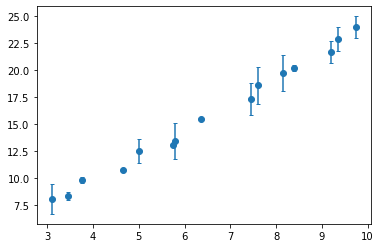

In [6]:
from scipy.optimize import curve_fit

# First get some y error from the DataFrame we've already read in
yerror = df['yerr']

# Plot it - with error bars
plt.errorbar(x, y, yerr=yerror, capsize=2, fmt='o')


In [7]:
# Once again, define a straight line model function.
def stLineFit(x, m, c):
    return (m*x + c)

# Call the fitting function - with, note,  2 retun values. The variables 'popt' and 'pcov' 
# are called this by convention but any 2 names would do.
popt, pcov = curve_fit(stLineFit, x, y, sigma=yerror, absolute_sigma=True)
# Calculate the 'accuracy' of the returned parameters
perr = np.sqrt(np.diag(pcov)) # error values are on the covariance matrix diagonal

#print fit parameters and 1-sigma estimates
print('fit parameter 1-sigma error')
print('***************************************************')
print (f'm = {popt[0]:.2f} +- {perr[0]:.2f}')
print (f'c = {popt[1]:.2f} +- {perr[1]:.2f}')
print('***************************************************')


fit parameter 1-sigma error
***************************************************
m = 2.42 +- 0.06
c = -0.11 +- 0.37
***************************************************


### 4.1 Confidence bounds or limits

You could now go on to just plot this new estimated line as before.

However, as you can see, we have more information about uncertainties in the gradient and the intercept and we could use this information to show a set of 'confidence' bound around it.

First calculate these bound lines

In [8]:
# prepare confidence level line limits
nstd = 1.0 # to draw 1 sigma interval
# Note, remember these are numpy arrays
popt_up = popt + nstd*perr
popt_dw = popt - nstd*perr

# Get the fitted line
fit = stLineFit(x, *popt)
# Add and subtract error values
fit_up = stLineFit(x, *popt_up)
fit_dw = stLineFit(x, *popt_dw)



Now plot it

<ErrorbarContainer object of 3 artists>

Text(0.5, 0, 'x')

Text(0, 0.5, 'y')

Text(0.5, 1.0, 'x Vs y with best fit line and 1 sigma confidence')

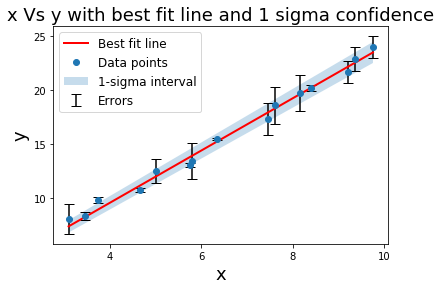

In [9]:
fig, ax = plt.subplots(1)
# Set plot parameters
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['font.size']= 2
plt.errorbar(x, y, yerr=yerror, capsize=5, fmt='none', ecolor='k', label='Errors')
plt.xlabel('x', fontsize=18)
plt.ylabel('y', fontsize=18)
plt.title('x Vs y with best fit line and 1 sigma confidence', fontsize=18)
plt.plot(x, fit, 'r', lw=2, label='Best fit line')
plt.plot(x, y0, 'o', lw=2, label='Data points')
ax.fill_between(x, fit_up, fit_dw, alpha=.25, label='1-sigma interval')
plt.legend(loc='upper left',fontsize=12)
plt.show()

## 5. X and Y errors

You'll note that so far we've ignored the errors in x. Linear regression tries to minimise the sum of the squares of the 'error' an in 'usual' use (as in curve_fit), the error is only considered in the 'y' value residual measured to the fitted line. In other words we are mimimising the residuals obtained by measuring a **vertical** distance from the data point to the model line. 

This is fine unless we have errors in both y AND x. In this case it is better to use the **orthoganal** distance from the data point to the fitted line - Orthogonal Distance Regression (ODR). 

Luckily there is a function for that. So, here we use it - the scipy **.odr()** function. Do note that we need to define the model function in a different way!


fit parameter 1-sigma error
***************************************************
m = 2.40 +- 0.12
c = 0.11 +- 0.74
***************************************************


<ErrorbarContainer object of 3 artists>

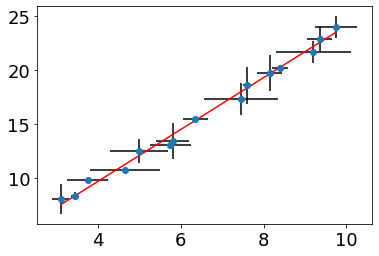

In [13]:
from scipy import odr

# Just a simple function to return a straight line for use in ODR.
# BUT, note that it is defined in a slightly different way to 'curve_fit()'
# You pass it a list/tuple of parameters and 'x' comes at the end - not first
def stLine(p,x):
    # 'p' is alist containing 'm' and 'c'
    m,c = p
    return m * x  + c

# We also need the x errors - so read them in
xerror=df['xerr']

# Need to use scipy 'odr' model for fitting. 
model = odr.Model(stLine)
# Form an odr 'RealData' object
rdata = odr.RealData(x,y,sx=xerror,sy=yerror)
# Now set up the ODR, 
# We need an initial 'guess' of m and c - beta0 
# We could 'hard wire' this but as we now we are looking at a straight line,
# we'll use scipy.stats.linregress() to get an estimate.
# We need the first 2 elements returned which are slope and intercept (m and c)
init_guess = linregress(x,y)[0:2]
odr=odr.ODR(rdata, model, beta0=init_guess )

# Run it and get the results
result_outputs = odr.run()

# Extract the data we need
popt = result_outputs.beta
# We can get a standard error using the line below (uncomment if you want to)
# perr = result_outputs.sd_beta
# But we'll use the covariance matrix to compute something closer to a 1 sigma confidence interval
perr = np.sqrt(np.diag(result_outputs.cov_beta))

#print fit parameters and 1-sigma estimates
print('fit parameter 1-sigma error')
print('***************************************************')
print (f'm = {popt[0]:.2f} +- {perr[0]:.2f}')
print (f'c = {popt[1]:.2f} +- {perr[1]:.2f}')
print('***************************************************')

# Now plot the data and fitted line:
#plt.scatter(x,y)
#plt.errorbar(x, y, yerr=yerror, xerr=xerror, hold=True, ecolor='k', fmt='none')
plt.errorbar(x, y, yerr=yerror, xerr=xerror, fmt='o', ecolor='k', label='Errors')
plt.plot(x, stLine((popt[0], popt[1]),x), color='red')


## 6. Using other models

the scipy 'curve_fit()' and 'odr()' functions allow you to define pretty much any model you want to fit your data.

As an example - and this will definitely prove useful later, a 'Gaussian' can be defined using 3 parameters:

$$a*np.exp(-(x-x0)**2/(2*sigma**2))$$

Where **a** is its amplitude, **x0** it's position on the x axis, and **sigma** a measure of it's width.

Let's have a look at  some noisy data that might typically come from, say, a thermally broadend spectral line. The physics of this indicate that a Gaussian should be a good model to use.

There is some demo data in the file 'gaus_rand.csv'. This has 2 columns of x and y values with column headers 'x' and 'y'. For your information, the data was generated using a=20, x0=10, sigma=1 with a random 'y' noise value added.

So, let's read it in, display it, do a fit, get the optimised parameters and display it. Here we'll, arbitarily, use Bokeh - Matplotlib would work just as well.

NOTE: Unlike the examples here, we've provided a list (called p0) as an extra parameter. This is optional but provides a set of 'guesses' of the parameters for the curv_fit() funtion to use as a starting point for the optimised values. It does in fact tend to be useful to provide this if your data is complex or noisy and tend to prevent non-optimal optimisations.


In [ ]:
output_notebook()

# define a Gaussian model
def gauss(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

# Read the data and do a quick-and-dirty plot
df = pd.read_csv('gaus_rand.csv')
df.plot('x', 'y', kind='scatter')

# Do the fit - here we provide a set of starting points for the parameters to be optimised
popt, pcov = curve_fit(gauss,df['x'],df['y'],p0=[20,10,2])

# What are the optimised parameters?
print('fit parameters')
print('***************************************************')
print ('a = ' + str(popt[0]))
print ('x0 = ' + str(popt[1]))
print ('sigma = ' + str(popt[2]))
print('***************************************************')

# Now we can also get the confidence interval (1-sigma in this case)
perr = np.sqrt(np.diag(pcov)) # error values are on the covariance matrix diagonal

#print fit parameters and 1-sigma estimates
print()
print('fit parameter 1-sigma error')
print('***************************************************')
print ('a = ' + str(popt[0])+' +- '+str(perr[0]))
print ('x0 = ' + str(popt[1])+' +- '+str(perr[1]))
print ('sigma = ' + str(popt[2])+' +- '+str(perr[2]))
print('***************************************************')

# Plot the data with the optimised curve:
p1 = figure(title = "Fitting a Gaussian to data", 
          x_axis_label='x', 
          y_axis_label='y')
p1.scatter(df['x'],df['y'], legend='Data')
p1.line(df['x'],gauss(df['x'],popt[0],popt[1],popt[2]), 
        color='red', 
        line_dash="dashed", 
        legend='Optimised curve')
p1.legend.location = "top_left"
p1.legend.click_policy="hide"
show(p1)



Although we have not gone into it here, .curve_fit() allows you to set 'bounds' for the optimised parameters. For example you might know that, due to constraints imposed by physical processes, there willl be a maximum FWHM/sigma for any Gaussian fitted, or you might want to ignore Gaussians that are too small in height, and so on. The official documentation is at https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html.


## 7. Fitting multiple peaks

However, what happens if we have more than one peak in the data?

We've provided a synthesised data set (twinPeaks.csv) that contains a pair of obvious peaks - you might get something like this when observing gaseous nebula using a narrow band OIII filter with a spectrometer. Don't forget this needs to be in the same directory as this notebook.

In [ ]:
%matplotlib inline
import pandas as pd
from scipy.optimize import curve_fit
from bokeh.plotting import figure, output_notebook, show
output_notebook()

# These 2 lines just allow 'pretty' printing of pandas stuff - non-essential
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Read the data and do a quick-and-dirty plot
df = pd.read_csv('twinPeaks.csv')
df.head()
df.plot('wavelength', 'intensity', kind='scatter')

Clearly we have two peaks that need fitting here - one (call it peak A) around channel 5050 and one (peak B)around channel 5085. We can also see that the first peak has a height of around 900 and a FWHM of around 10, the second a height of about 200 and a FWHM of 10.

There are a number of ways to deal with this and we'll look at 2.

### 7.1 Isolate the specific area of interest.

We could just isolate the area of interest by using slices of the overall data and repeat. Here we'll prompt the user for 3 bits of information:

1. An estimate of the 'x' position of the peak of interest.
2. An estimate of the height.
3. An estimate of the FWHM - this will allow us to isolate a sloce of data and also give us a begining sigma.

Note a couple of things here:

* There is a generally accepted relationship for a Gaussian where FWHM is approximately 2.35482 * sigma.
* Watch out for data where the x axis values don't start at 0. When you need to slice the data, you would naturally tend to use .iloc (see UsingPandas). BUT for data where the data does NOT start at 0, the data index and actual data will be 'out of step'. Get around this by indexing the DataFrame on the 'x' values and using .loc.

In [ ]:
# define a Gaussian model
def gauss(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

# Having inspected the spectrum, get some fit estimates
x0est = int(input('Estimated peak position? '))
aest = float(input('Estimated peak height? '))
FWHMest = float(input('Estimated peak FWHM? '))


# Calculate an estimates sigma from the accepted relationship FWHM approx = 2.35 * sigma
sigmaest = FWHMest/2.35

# We need to re-index the DataFrame on the channel data 
# This is necessary so that we can 'slice' the data based on the displayed wavelength rather
# than the actual data index.
df.set_index('wavelength', inplace=True, drop=False)

# Get area of interest 
x = df['wavelength'].loc[x0est-FWHMest : x0est+FWHMest]
y = df['intensity'].loc[x0est-FWHMest : x0est+FWHMest]

# do the fit
popt, pcov = curve_fit(gauss,x,y,p0=[aest,x0est,sigmaest])

# What are the optimised parameters?
print('fit parameters')
print('***************************************************')
print ('a = ' + str(popt[0]))
print ('x0 = ' + str(popt[1]))
print ('sigma = ' + str(popt[2]))
print('***************************************************')

# Plot to check it (Matplotlib): 
# plt.plot(df['wavelength'],df['intensity'], label='Data', color='lightgrey', linewidth=5)
# plt.plot(df['wavelength'],gauss(df['wavelength'],popt[0],popt[1],popt[2]), 'r--')

# Plot the data with the optimised curve (Bokeh):
p1 = figure(title = "Fitting a Gaussian to multiple peaks", 
          x_axis_label='Wavelength (Angstroms)', 
          y_axis_label='Intensity')
p1.scatter(df['wavelength'],df['intensity'], legend='Data')
p1.line(df['wavelength'],gauss(df['wavelength'],popt[0],popt[1],popt[2]), 
        color='red', 
        line_dash="dashed", 
        legend='Optimised curve')
p1.legend.location = "top_left"
p1.legend.click_policy="hide"
show(p1)



You could now repeat for peak B - either by re-running the code or putting the whole thing in a loop.



### 7.2 Create a more complex 'gauss' function

We can also approach the problem by using a 'gauss' function that actually assumes we need 2 gaussians for a curve_fit.

In [ ]:
# define a 2 Gaussian model
def gauss2(x, a1, x10, sigma1, a2, x20, sigma2):
    return a1*np.exp(-(x-x10)**2/(2*sigma1**2))+ a2*np.exp(-(x-x20)**2/(2*sigma2**2))


As before we could prompt the user for the initial estimates. Here, however, for brevity we'll hard-code them.


In [ ]:
x10est = 5050
x20est = 5080
a1est = 900
a2est = 200
# We won't be using FWHM here so we'll just use sigma estimates - once again for brevity
sigma1est = 10/2.35
sigma2est = 10/2.35

# We'll stick these into a list for ease of handling
p0 = [a1est, x10est, sigma1est, a2est, x20est, sigma2est]

# x and y are:
x = df['wavelength']
y = df['intensity']

# do the fit
popt, pcov = curve_fit(gauss2,x,y,p0)

# What are the optimised parameters?
print('fit parameters')
print('***************************************************')
print ('a1 = ' + str(popt[0]))
print ('x10 = ' + str(popt[1]))
print ('sigma1 = ' + str(popt[2]))
print ('a2 = ' + str(popt[3]))
print ('x20 = ' + str(popt[4]))
print ('sigma2 = ' + str(popt[5]))
print('***************************************************')
print(f'Peaks are at wavelegths of {popt[1]:.0f} and {popt[4]:.0f} Angstroms')
print('***************************************************')

# Plot it (Matplotlib)
# plt.plot(df['wavelength'],df['intensity'], label='Data', color='lightgrey', linewidth=5)
# plt.plot(df['wavelength'],gauss2(df['wavelength'],popt[0],popt[1],popt[2],
#                                popt[3], popt[4], popt[5]), 'r--')

# Plot the data with the optimised curve (Bokeh):
p1 = figure(title = "Fitting a Gaussian to multiple peaks", 
          x_axis_label='Wavelength (Angstroms)', 
          y_axis_label='Intensity')
p1.scatter(df['wavelength'],df['intensity'], legend='Data')
p1.line(df['wavelength'],gauss2(df['wavelength'],popt[0],popt[1],popt[2], \
                              popt[3], popt[4], popt[5]), 
        color='red', 
        line_dash="dashed", 
        legend='Optimised curve')
p1.legend.location = "top_left"
p1.legend.click_policy="hide"
show(p1)